In [2]:
#conda-env-analysis3-20.01
import sys
sys.path.append('/g/data1a/e14/as3189/OFAM/scripts/')
import gsw
import numpy as np
import xarray as xr
from scipy import stats
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt
from main import paths, idx_1d, LAT_DEG, lx
from matplotlib.offsetbox import AnchoredText
from main_valid import EUC_depths, plot_eq_velocity
from main_valid import open_tao_data, plot_tao_timeseries, cor_scatter_plot
import datetime

In [3]:
# Path to save figures, save data and OFAM model output.
fpath, dpath, xpath, lpath, tpath = paths()

z1 = 50
z2 = 300
dt = xr.open_dataset(dpath.joinpath('ofam_ocean_u_EUC_int_transport.nc'))
dt = dt.sel(st_ocean=slice(z1, z2))


In [7]:
# Add transport between depths.
dtt = dt.uvo.isel(st_ocean=0).copy()*np.nan

# Add velocity between depths.
dv = dt.u.isel(st_ocean=0).copy()*np.nan

for i in range(3):
    dq = dt.sel(xu_ocean=lx['lons'][i])
    v_max, depth_vmax, depth_end = EUC_depths(dq.u, dq.st_ocean, i)
    for t in range(len(dt.Time)):
        if not np.isnan(depth_end[t]):
            # Transport
            tmp1 = dt.uvo.isel(xu_ocean=i, Time=t)
            dtt[t, i] = tmp1.where(tmp1 > 0).sel(
                st_ocean=slice(z1, depth_end[t].item())).sum(dim='st_ocean').item()
            # Velocity
            tmp2 = dt.u.isel(xu_ocean=i, Time=t)
            dv[t, i] = tmp2.where(tmp2 > 0).sel(
                st_ocean=slice(z1, depth_end[t].item())).sum(dim='st_ocean').item()           

INFO: OFAM3 165: v_bnd=0.1 count=305 tot=384, skipped=79 empty=0 eps=0.05.
INFO: EUC_depths: 0:0:00.34 total: 0.34 seconds.
INFO: OFAM3 190: v_bnd=0.1 count=249 tot=384, skipped=135 empty=0 eps=0.05.
INFO: EUC_depths: 0:0:00.25 total: 0.25 seconds.
INFO: OFAM3 220: v_bnd=0.1 count=301 tot=384, skipped=83 empty=0 eps=0.05.
INFO: EUC_depths: 0:0:00.28 total: 0.28 seconds.


SpearmanrResult(correlation=0.9229580097785447, pvalue=1.1378140160829023e-127)
slope=0.45, intercept=0.61, r_value=0.89, p_value=0.00, std_err=0.01
SpearmanrResult(correlation=0.8903476024910516, pvalue=3.252182583005194e-105)
slope=0.46, intercept=4.07, r_value=0.88, p_value=0.00, std_err=0.01
SpearmanrResult(correlation=0.7680701074881862, pvalue=5.070536885181927e-60)
slope=0.55, intercept=10.26, r_value=0.80, p_value=0.00, std_err=0.02


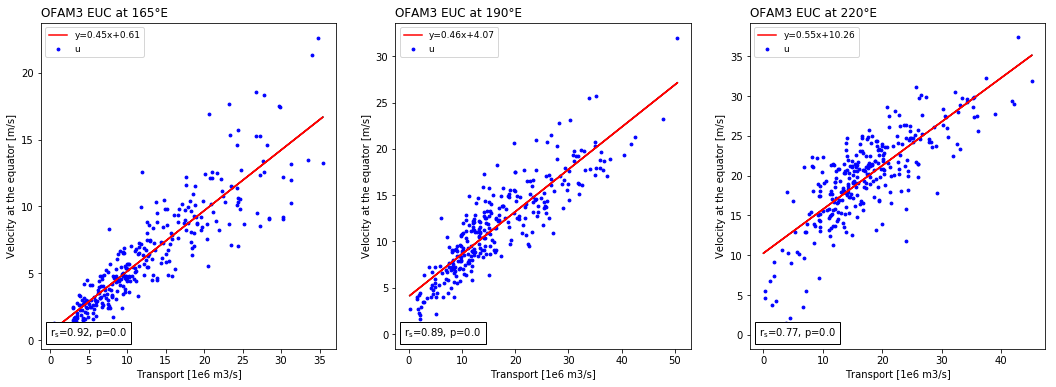

In [25]:
fig = plt.figure(figsize=(18, 6))
slope = np.zeros(3)
intercept = np.zeros(3)
for i in range(3):
    slope[i], intercept[i] = cor_scatter_plot(fig, i+1, dtt.isel(xu_ocean=i)/1e6, dv.isel(xu_ocean=i), 
                                              name='OFAM3 EUC at {}°E'.format(lons[i]))

In [7]:
# plt.plot(dtt.Time, dtt.isel(xu_ocean=i)/1e6)

# TAO transport

In [26]:
T = 1
freq = ['daily', 'monthy'][T]
freqx = ['day', 'mon'][T]
fx = ['dy', 'mon'][T]
lons = [165, 190, 220]

# Open data sets at each longitude.
dU_165 = xr.open_dataset(tpath.joinpath('adcp0n165e_{}.cdf'.format(fx))).sel(lat=0, lon=165, depth=slice(z1, z2))
dU_190 = xr.open_dataset(tpath.joinpath('adcp0n170w_{}.cdf'.format(fx))).sel(lat=0, lon=190, depth=slice(z1, z2))
dU_220 = xr.open_dataset(tpath.joinpath('adcp0n140w_{}.cdf'.format(fx))).sel(lat=0, lon=220, depth=slice(z1, z2))

missing_value = dU_165.missing_value # 1e35

# Remove empty times?
du_165 = dU_165.where(dU_165['u_1205'] != missing_value).resample(time='MS').asfreq()/100
du_190 = dU_190.where(dU_190['u_1205'] != missing_value).resample(time='MS').asfreq()/100
du_220 = dU_220.where(dU_220['u_1205'] != missing_value).resample(time='MS').asfreq()/100
ds = [du_165, du_190, du_220]

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [27]:

ds_sum = [ds[i].u_1205.isel(depth=0)*np.nan for i in range(3)]
for i in range(3):
    mn_depth_tao = EUC_depths_tao(ds[i].u_1205, i, min_v=0.1, eps=0.05)[1]
    for t in range(len(ds[i].u_1205.time)):
        if not np.isnan(mn_depth_tao[t]):
            tmp = ds[i].u_1205.isel(time=t)
            ds_sum[i][t] = tmp.where(tmp > 0).sel(depth=slice(z1, mn_depth_tao[t])).sum(dim='depth').item()

165: Min velocity=0.1, included=73, total=203, skipped=109, Empty=21, eps=0.05
190: Min velocity=0.1, included=193, total=340, skipped=105, Empty=42, eps=0.05
220: Min velocity=0.1, included=227, total=311, skipped=49, Empty=35, eps=0.05


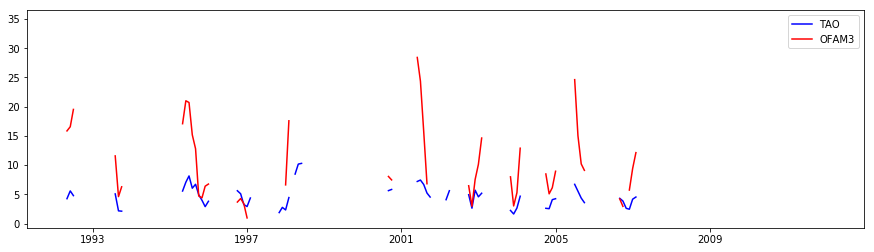

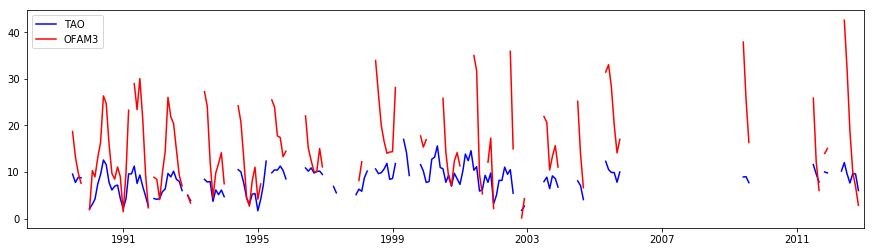

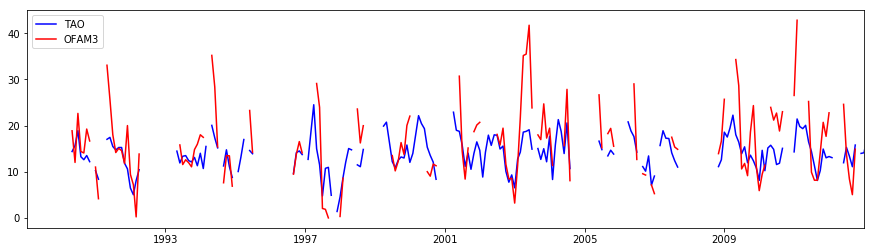

In [28]:
for i in range(3):
    fig = plt.subplots(figsize=(15, 4))

    dttt = dtt.isel(xu_ocean=i).where(np.isnan(ds_sum[i].rename({'time': 'Time'})) == False)
    plt.plot(ds_sum[i].time, ds_sum[i]*slope[i], color='blue', label='TAO')
    plt.plot(dttt.Time, dttt/1e6, color='red', label='OFAM3')

    plt.xlim(xmax=datetime.date(2012, 12 ,31))
    plt.legend()